# Download the Data

In [1]:
!pip3 install tqdm

In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [4]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [8]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [9]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [10]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5911
1438


# Visualize Data

In [11]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['keeshond', 'Siamese', 'Bengal', 'miniature_pinscher', 'english_cocker_spaniel', 'boxer', 'Maine_Coon', 'scottish_terrier', 'newfoundland', 'german_shorthaired', 'english_setter', 'wheaten_terrier', 'yorkshire_terrier', 'pomeranian', 'havanese', 'saint_bernard', 'Birman', 'pug', 'British_Shorthair', 'basset_hound', 'chihuahua', 'shiba_inu', 'samoyed', 'Ragdoll', 'Persian', 'Sphynx', 'american_bulldog', 'Abyssinian', 'Egyptian_Mau', 'Russian_Blue', 'japanese_chin', 'Bombay', 'staffordshire_bull_terrier', 'beagle', 'great_pyrenees', 'american_pit_bull_terrier', 'leonberger']

Num of classes: 37


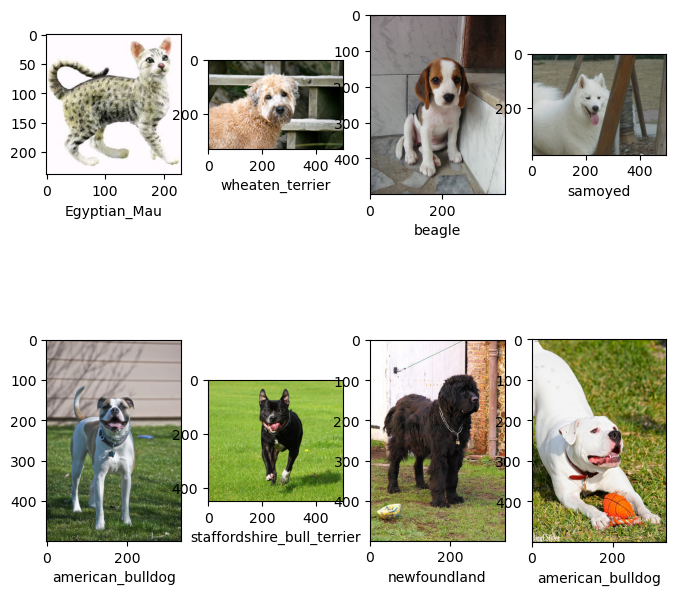

In [12]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [21]:
role = sagemaker.get_execution_role()
bucket_name ='image-classification-petsdata'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification',
                              repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


644912444149.dkr.ecr.eu-west-2.amazonaws.com/image-classification:1


In [16]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [17]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [18]:
prepare_data(train_annotations, 'train')

100%|██████████| 5911/5911 [00:05<00:00, 1052.16it/s]


In [19]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1438/1438 [00:02<00:00, 592.63it/s]


# Uploading Data to S3

In [25]:
%%time
sess = sagemaker.Session()
s3_train_path = sess.upload_data(path='train',bucket= bucket_name, key_prefix='train')
print('Train images uploaded')
s3_train_lst_path = sess.upload_data(path='train_lst',bucket= bucket_name, key_prefix='train_lst')
print('Train list uploaded')
s3_validation_path = sess.upload_data(path='validation',bucket= bucket_name, key_prefix='validation')
print('Validation images uploaded')
s3_validation_lst_path = sess.upload_data(path='validation_lst',bucket= bucket_name, key_prefix='validation_lst')
print('Validation list uploaded')

Train images uploaded
Train list uploaded
Validation images uploaded
Validation list uploaded
CPU times: user 47.8 s, sys: 4.63 s, total: 52.4 s
Wall time: 6min 41s


In [26]:
print(s3_train_path)

s3://image-classification-petsdata/train


# SageMaker Estimator

In [60]:
model=sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size= 100,
    max_run = 36000,
    input_mode='File',
    output_path = 's3://image-classification-petsdata/output',
    sagemaker_session = sess
)

# Hyperparameters

In [61]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=37,
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=train_count,
    augmentation_type='crop_color_transform'
)
print(model.hyperparameters())

# Data Channels

In [62]:
train_data=sagemaker.session.TrainingInput(s3_train_path, distribution='FullyReplicated',
                                      content_type='application/x-image', s3_data_type='S3Prefix')
validation_data=sagemaker.session.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                                      content_type='application/x-image', s3_data_type='S3Prefix')
train_lst_data=sagemaker.session.TrainingInput(s3_train_lst_path, distribution='FullyReplicated',
                                      content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data=sagemaker.session.TrainingInput(s3_validation_lst_path, distribution='FullyReplicated',
                                            content_type='application/x-image', s3_data_type='S3Prefix')

In [63]:
data_channels={
    'train': train_data,
    'train_lst':train_lst_data,
    'validation': validation_data,
    'validation_lst':validation_lst_data
}

# Model Training

In [64]:
model.fit(inputs= data_channels, logs=True )

INFO:sagemaker:Creating training-job with name: image-classification-2024-06-21-09-46-51-681


2024-06-21 09:46:51 Starting - Starting the training job.........
2024-06-21 09:48:04 Pending - Training job waiting for capacity......
2024-06-21 09:49:03 Pending - Preparing the instances for training...
2024-06-21 09:49:40 Downloading - Downloading input data...
2024-06-21 09:50:21 Downloading - Downloading the training image.........
2024-06-21 09:51:31 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Jun 21 09:51:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncor

# Deploy Model

In [65]:
deployed_model = model.deploy(initial_instance_count = 1, instance_type = "ml.m4.xlarge")
print('\nModel deployed!')

INFO:sagemaker:Creating model with name: image-classification-2024-06-21-09-55-10-978
INFO:sagemaker:Creating endpoint-config with name image-classification-2024-06-21-09-55-10-978
INFO:sagemaker:Creating endpoint with name image-classification-2024-06-21-09-55-10-978


--------!
Model deployed!


# Predictions

In [67]:
image_dir = "validation"
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg' ]
print(len(images))

1438


In [69]:
deployed_model.content_type = 'image/jpeg'

In [77]:
index = 0
image_path = os.path.join(image_dir, images[index])
print(image_path)
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
results = deployed_model.predict(b)
results = json.loads(results)
print(results)

validation/miniature_pinscher_148.jpg
[9.755437986314064e-07, 4.027318937005475e-06, 2.6857176749217615e-07, 0.9637309312820435, 6.211951841805785e-08, 0.00013170012971386313, 1.2682095373861557e-08, 1.4897997289153864e-06, 1.10037149170239e-06, 0.011827228590846062, 1.0300102530891309e-06, 8.25453480501892e-06, 4.466889731702395e-05, 3.0155473496051854e-07, 4.90144259401859e-07, 2.96719645120902e-05, 2.7025711446526657e-08, 0.007265162188559771, 1.5257235475019115e-07, 0.00035449754795990884, 0.0010246443562209606, 0.0010450001573190093, 7.73725059843855e-06, 1.6873086394753045e-07, 5.749896558882028e-08, 0.00014809843560215086, 2.4679977741470793e-06, 1.4343198017741088e-05, 2.0502093320828862e-05, 0.0002429098094580695, 0.0001536167983431369, 4.2934188968501985e-05, 0.002735753543674946, 3.173973163939081e-05, 2.2253718725551153e-06, 0.011123942211270332, 1.956350388354622e-06]


In [78]:
classes[np.argmax(results)]

'miniature_pinscher'

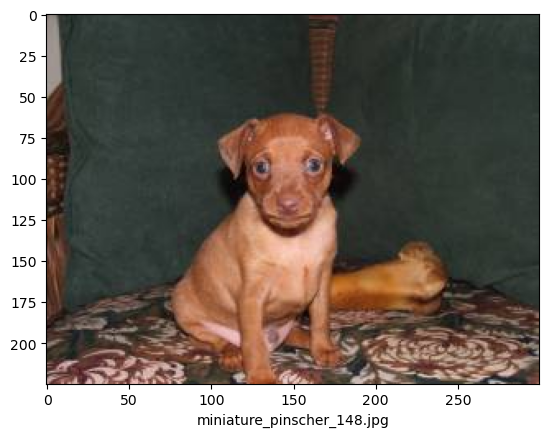

In [79]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)